Bar chart of the Total Area of Temporary Crops by Year (of all Freguesias in Portugal):

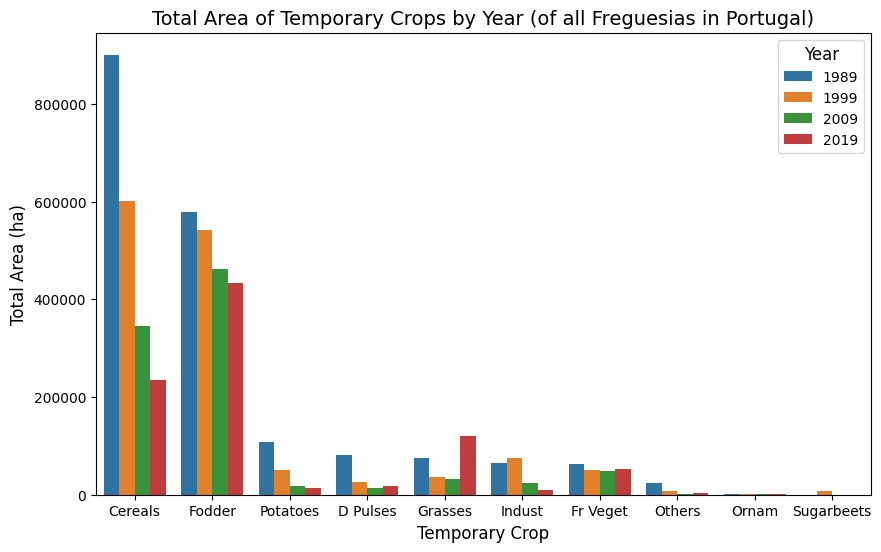

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data from a CSV file
data = pd.read_csv('3_temp_crops.csv')

# Rename the columns
data.rename(columns={'Area_1989': '1989'}, inplace=True)
data.rename(columns={'Area_1999': '1999'}, inplace=True)
data.rename(columns={'Area_2009': '2009'}, inplace=True)
data.rename(columns={'Area_2019': '2019'}, inplace=True)

# Group the data by crop and calculate the total area for each crop
crop_totals_1989 = data.groupby('Temp_crop')[['1989', '1999', '2009', '2019']].sum().reset_index()

# Sort the data by total area in descending order
crop_totals_1989 = crop_totals_1989.sort_values('1989', ascending=False)

# Create custom abbreviations for x-axis labels
abbreviations = ['Cereals', 'Fodder', 'Potatoes', 'D Pulses', 'Grasses', 'Indust', 'Fr Veget', 'Others', 'Ornam', 'Sugarbeets']  # Update with desired abbreviations

# Add the abbreviations as a new column in crop_totals DataFrame
crop_totals_1989['Abbreviation'] = abbreviations

# Melt the data to convert the year columns into a single 'Year' column
melted_data = pd.melt(crop_totals_1989, id_vars=['Temp_crop', 'Abbreviation'], var_name='Year', value_name='Total_Area')

# Create a bar chart to visualize the total area for each crop over the years
plt.figure(figsize=(10, 6))
sns.barplot(x='Temp_crop', y='Total_Area', hue='Year', data=melted_data)
plt.xlabel('Temporary Crop', fontsize=12)
plt.ylabel('Total Area (ha)', fontsize=12)
plt.title('Total Area of Temporary Crops by Year (of all Freguesias in Portugal)', fontsize=14)
plt.xticks(range(len(crop_totals_1989)), abbreviations, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Year', fontsize=10, title_fontsize=12, loc='upper right')
plt.show()


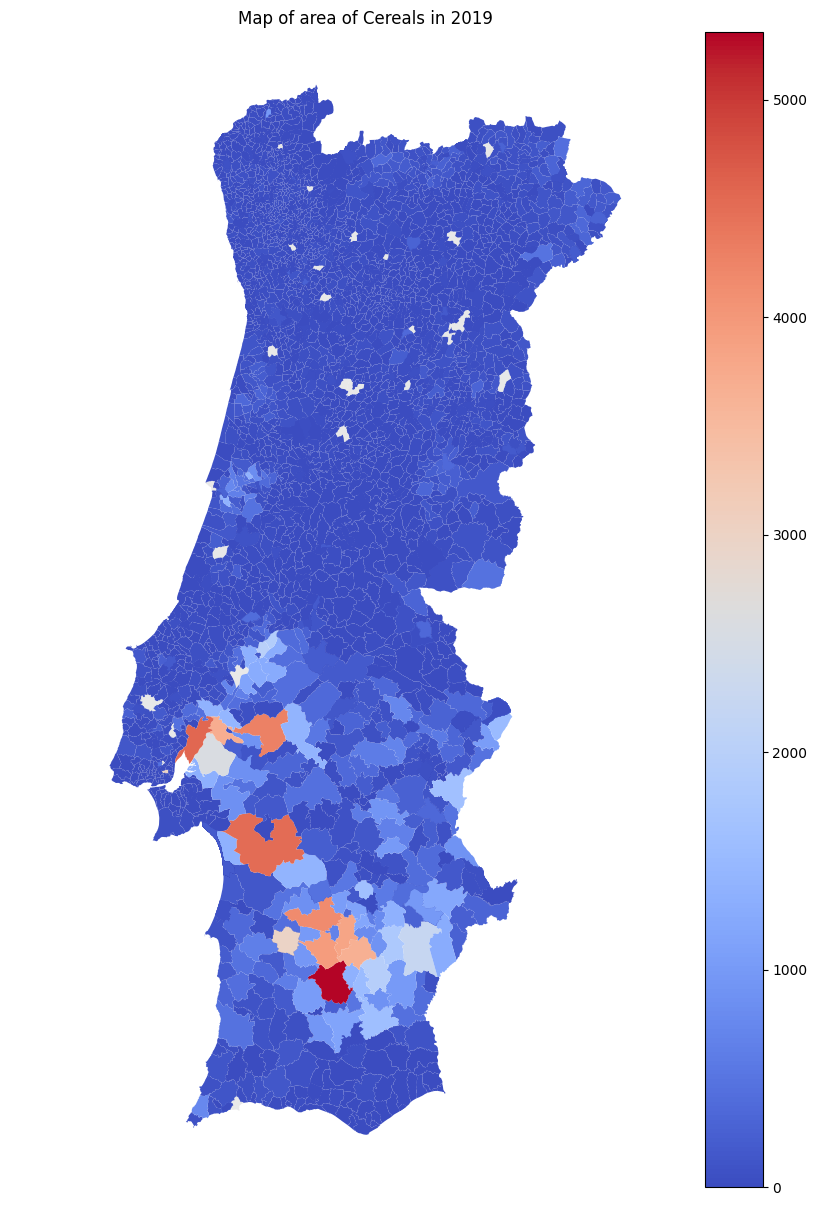

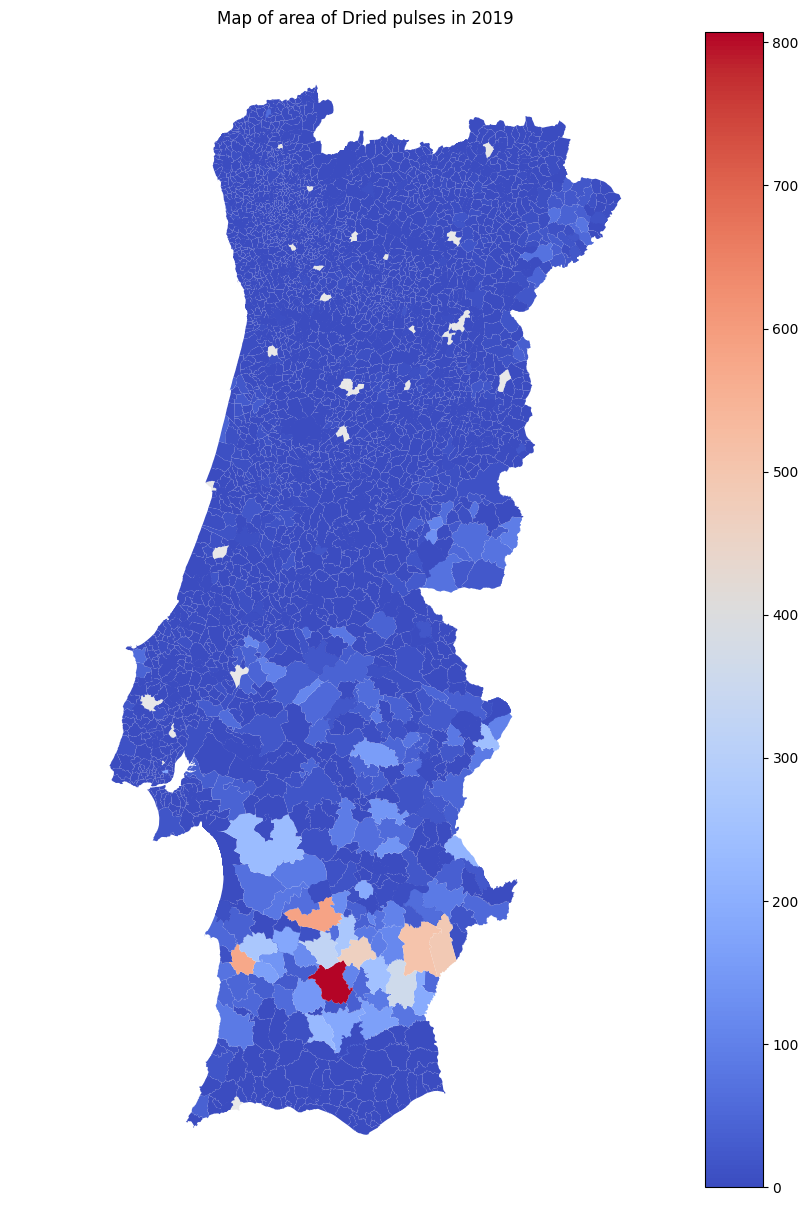

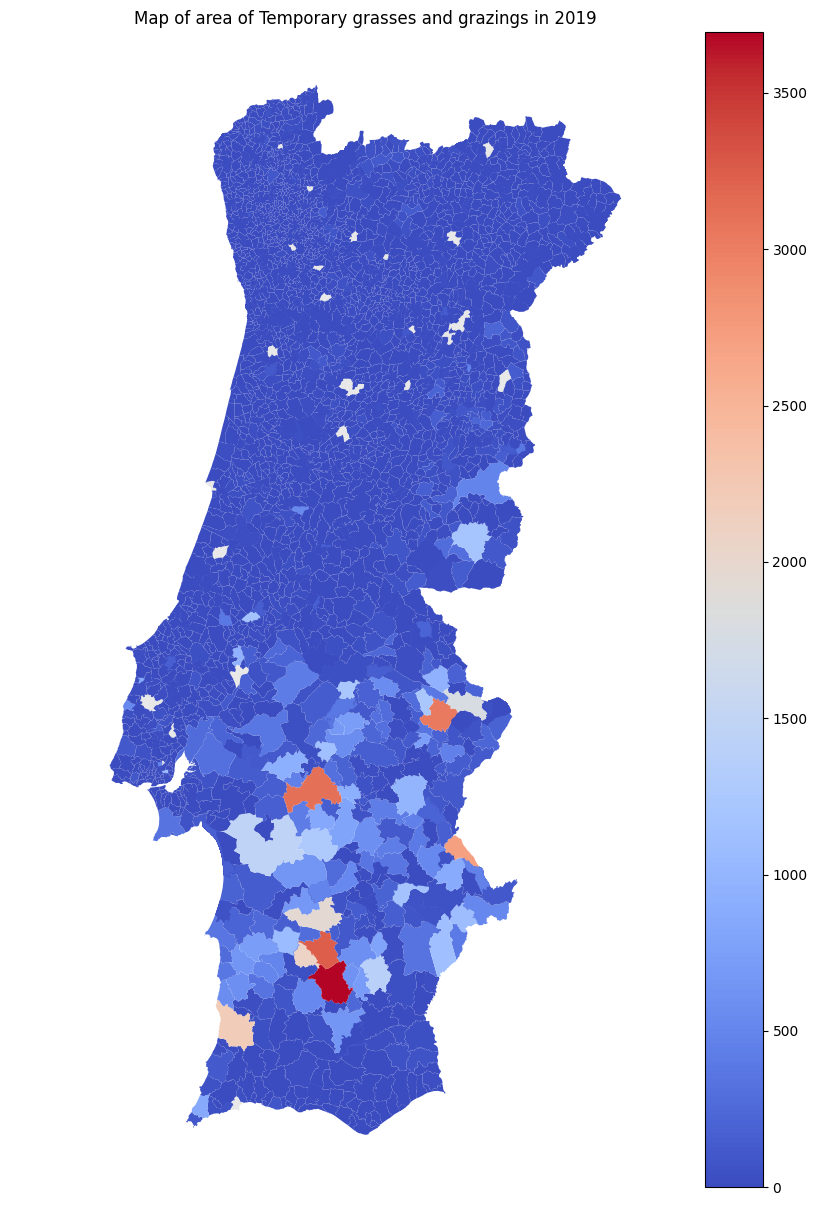

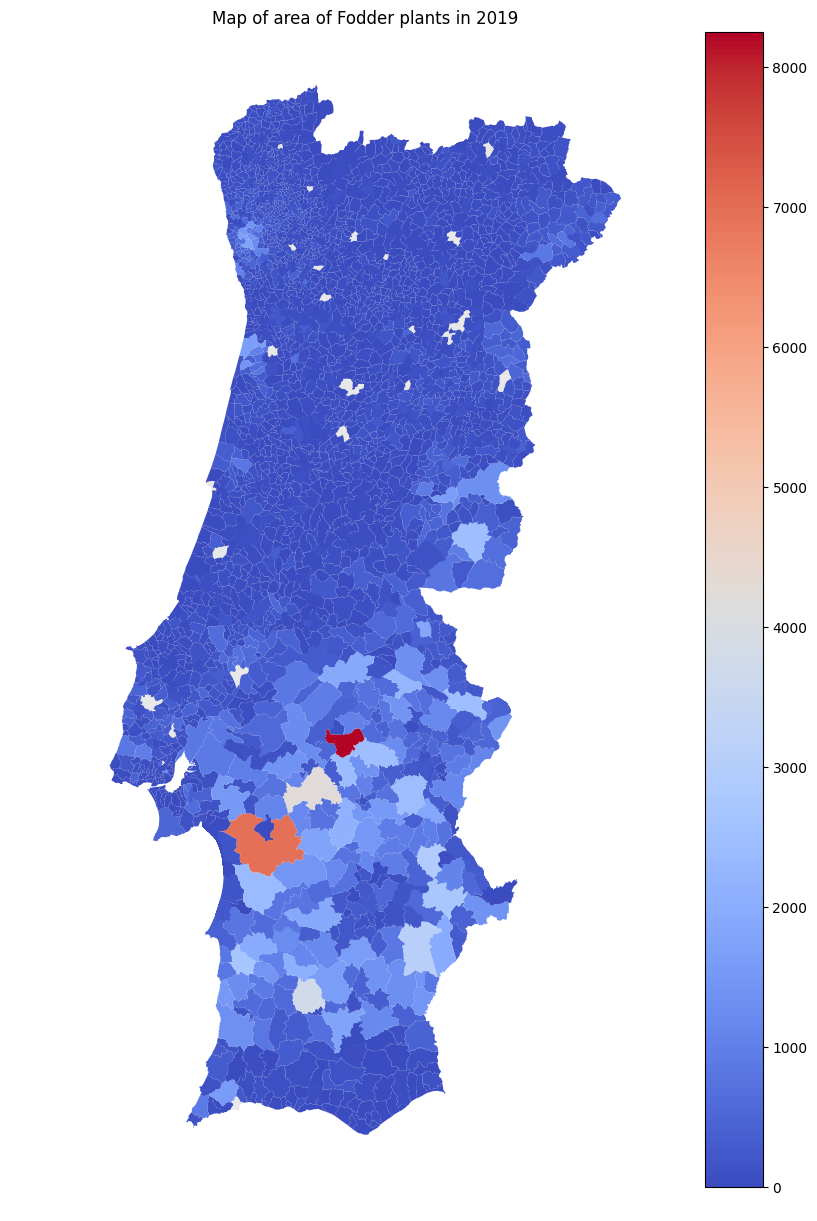

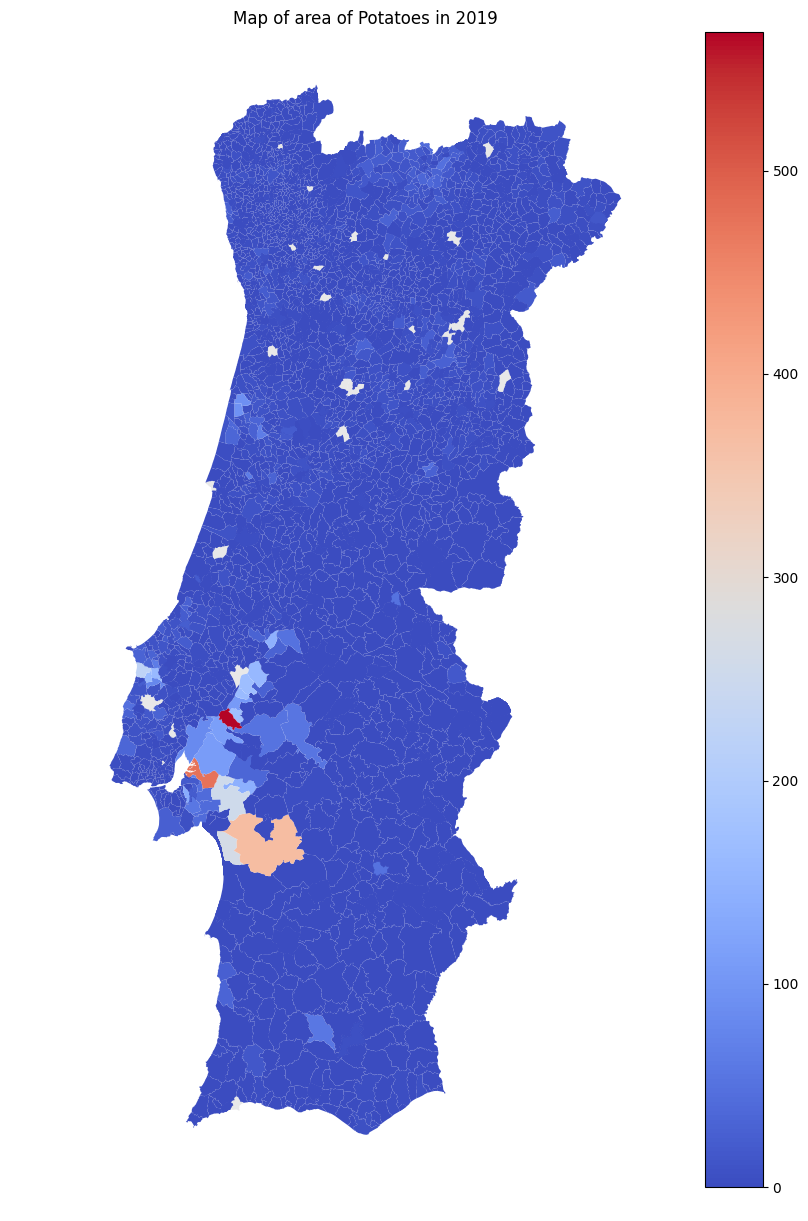

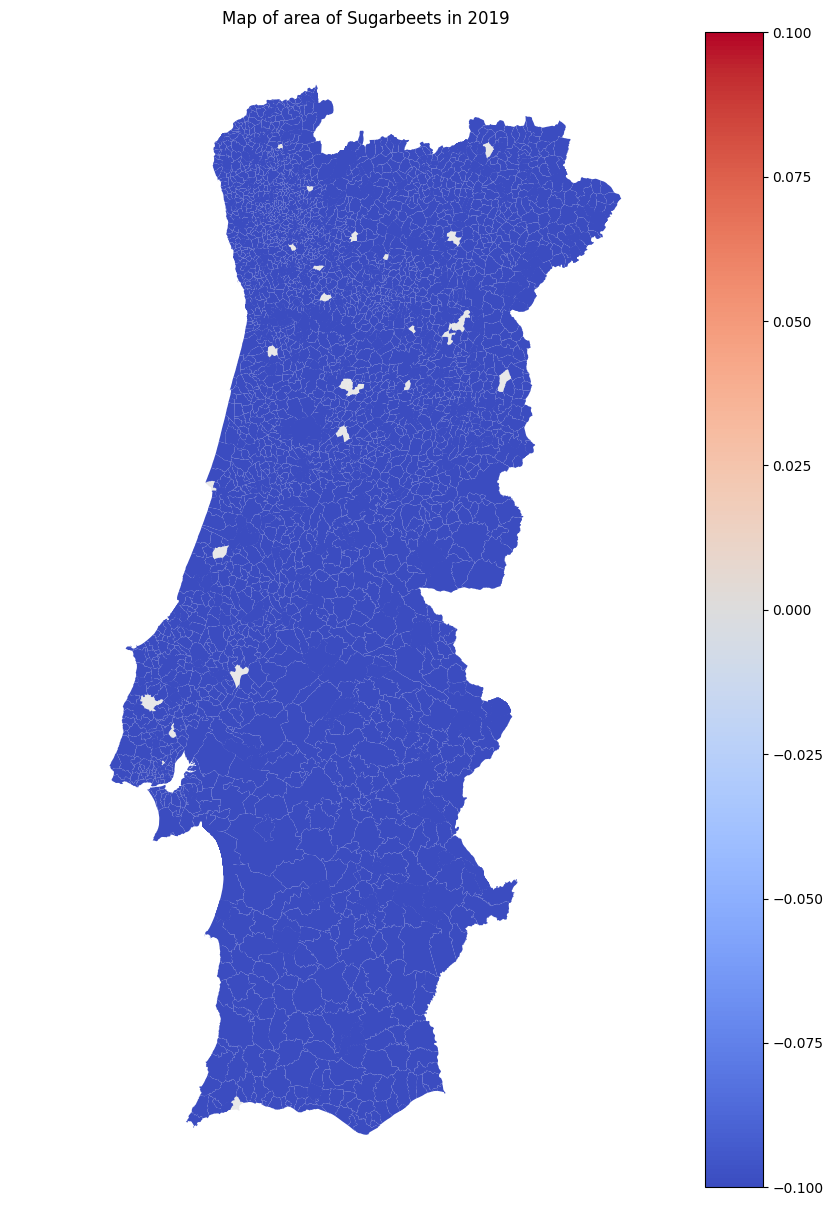

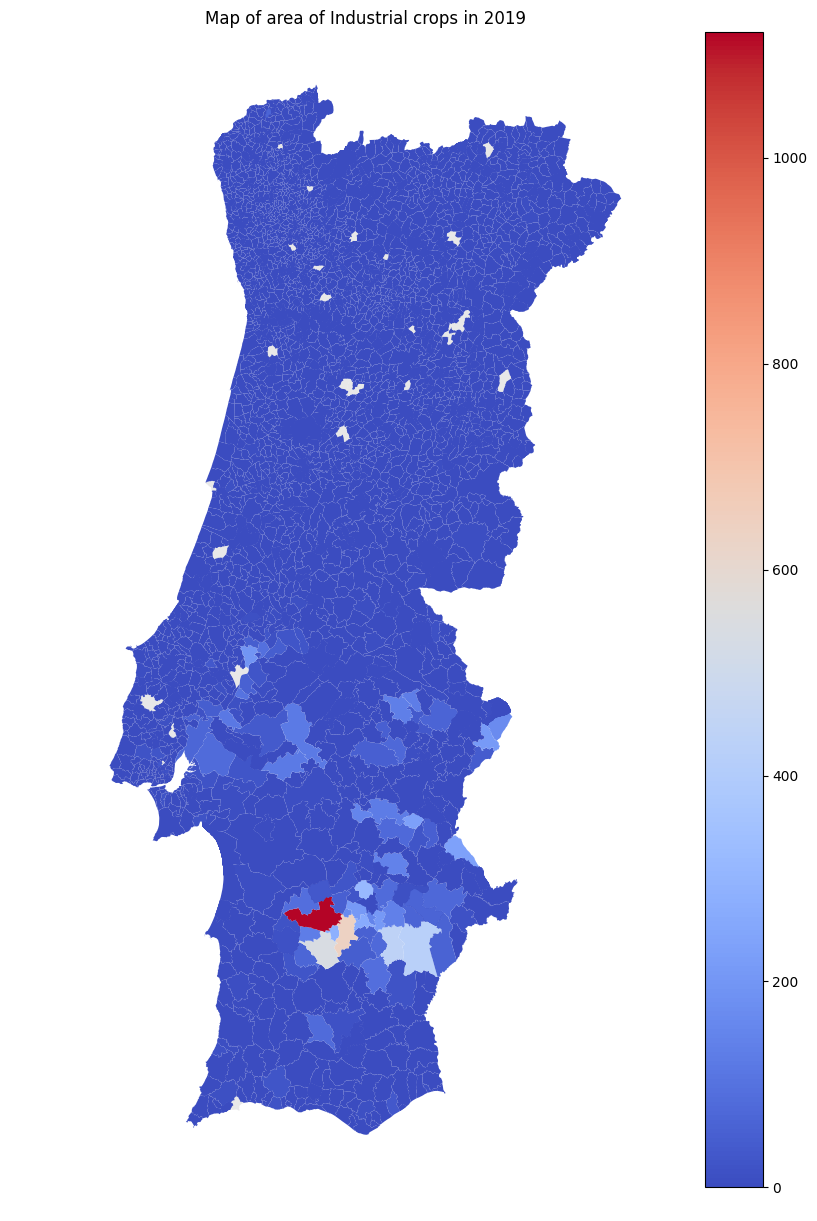

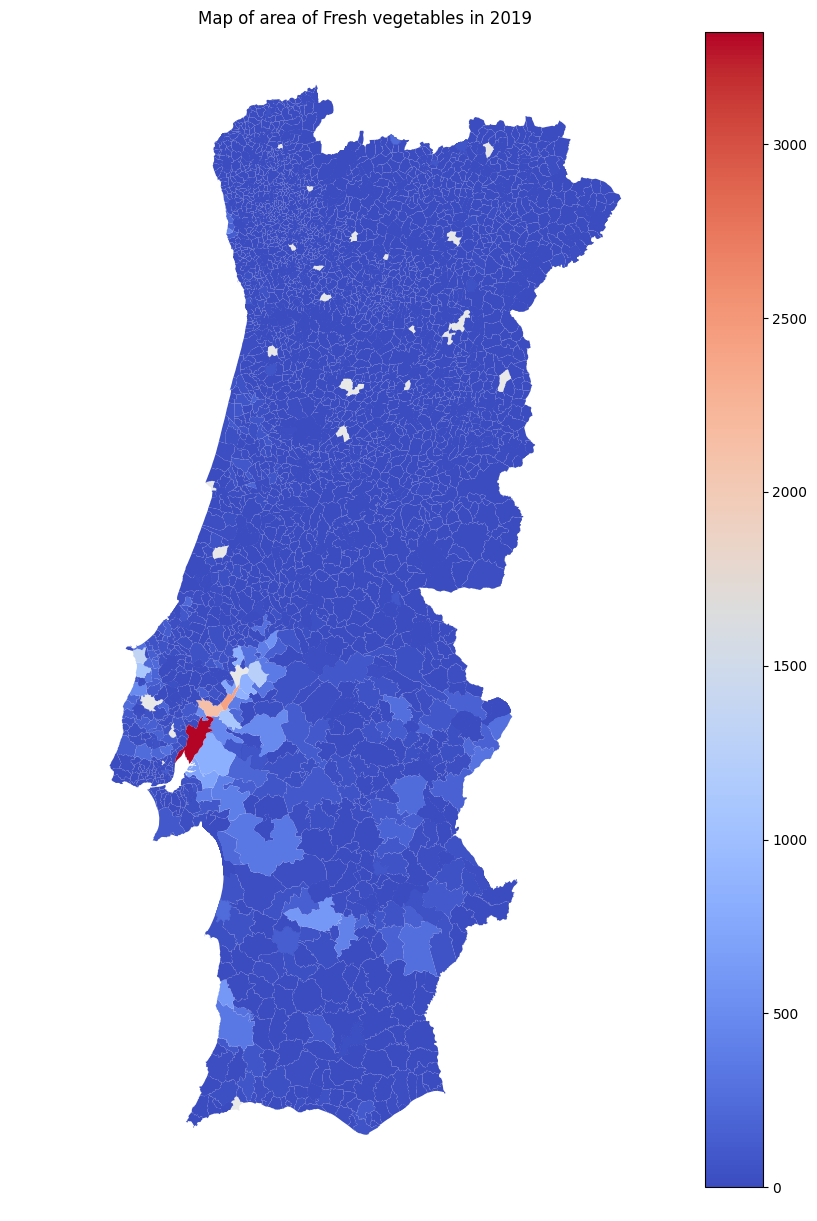

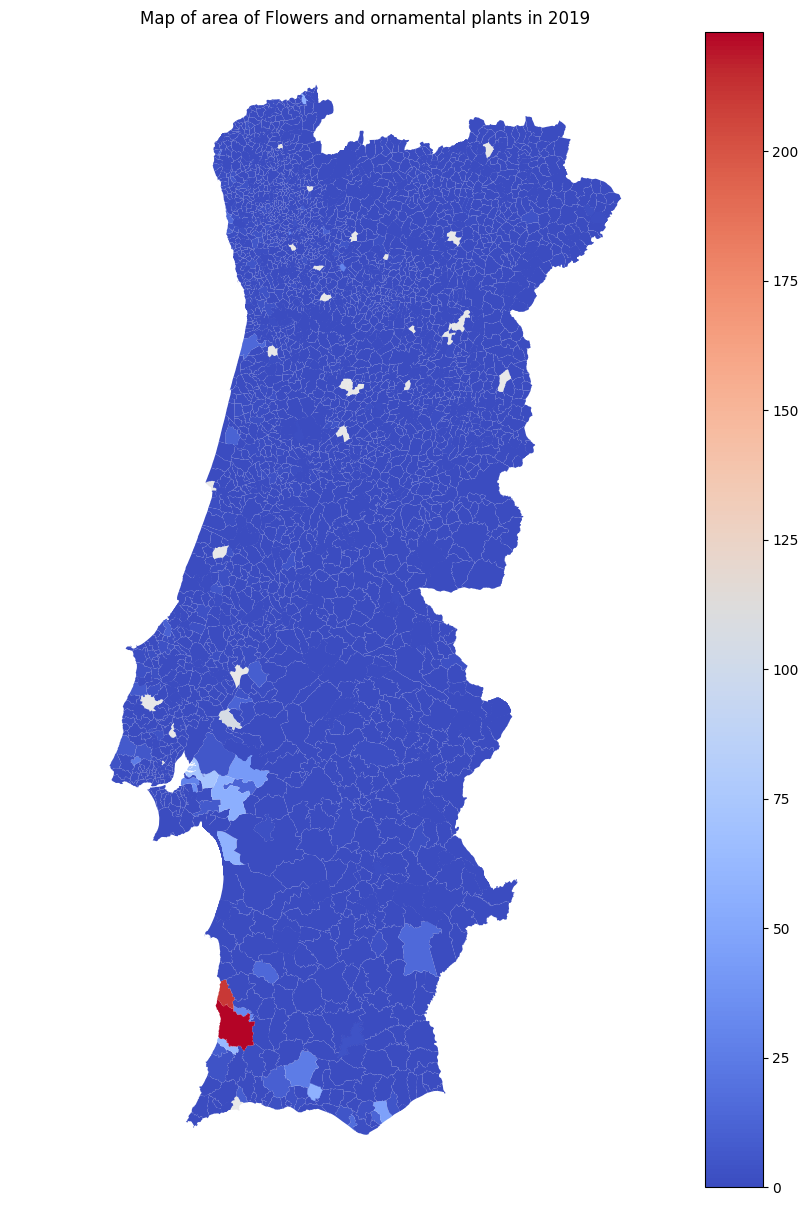

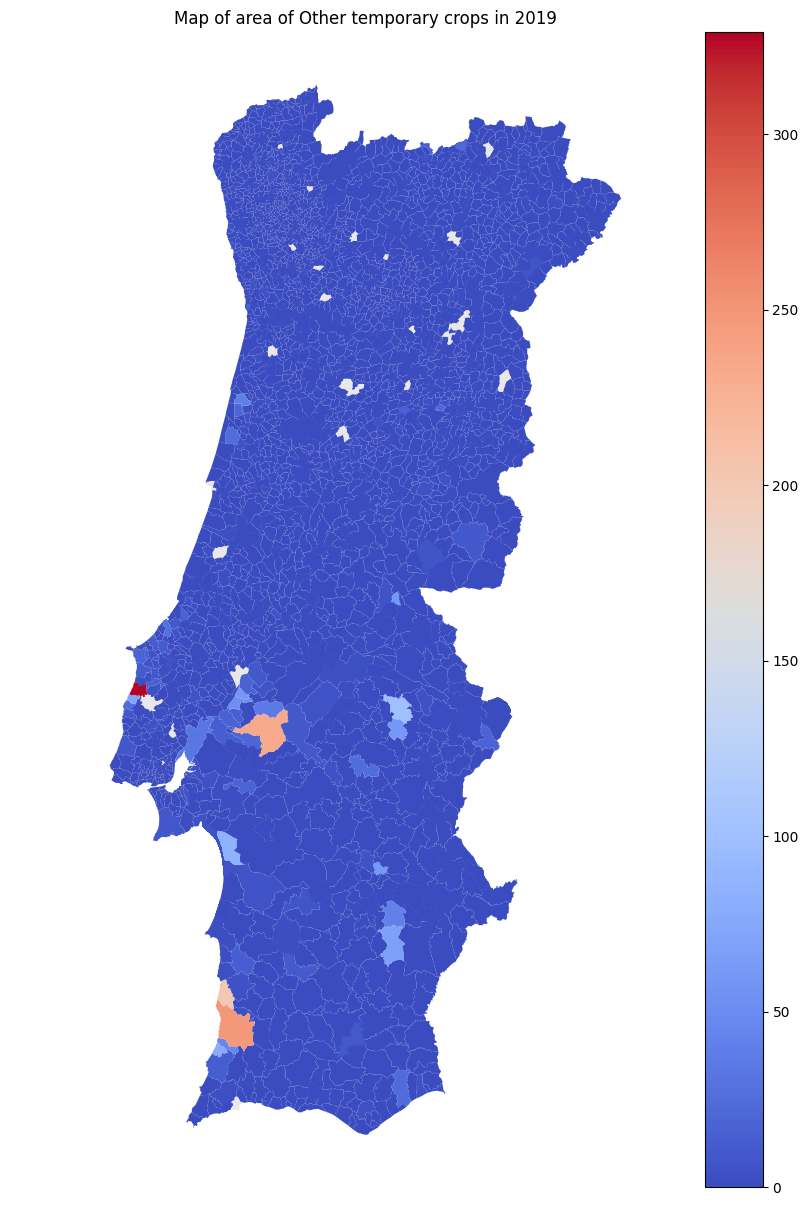

In [25]:
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from dbfread import DBF

# Set the SHAPE_RESTORE_SHX environment variable to YES
os.environ["SHAPE_RESTORE_SHX"] = "YES"

# Step 1: Read the shapefile using GeoPandas
shapefile_path = 'Cont_AAD_CAOP2017.shp'
map_data = gpd.read_file(shapefile_path, encoding='utf-8')

# Step 2: Read the attribute data from the DBF file using dbfread
dbf_file_path = 'Cont_AAD_CAOP2017.dbf'
attribute_data = pd.DataFrame(iter(DBF(dbf_file_path, encoding='utf-8')))
 

# Step 3: Read the database CSV using pandas
csv_path = '3_temp_crops.csv'
database = pd.read_csv(csv_path)

# Step 4: Connect the shapefile and attribute data based on a common column
common_column = 'Freguesia'
merged_data = map_data.merge(attribute_data, on=common_column)

# Step 5: Merge with the database based on a common column
merged_data = merged_data.merge(database, left_on='Freguesia', right_on='region_name')

# Step 6: Plot a map for each crop
crops = database['Temp_crop'].unique()  # Get unique crop names

# Set the CRS for the map_data
map_data.crs = merged_data.crs

# Set the map extent to cover all data
minx, miny, maxx, maxy = merged_data.total_bounds
map_data = map_data.cx[minx:maxx, miny:maxy]

# Iterate over crops and plot maps
for crop in crops:
    fig, ax = plt.subplots(figsize=(15, 15))
    
    # Filter merged data for the specific crop
    crop_data = merged_data[merged_data['Temp_crop'] == crop]
    
    # Plot the merged data without outlines
    crop_data.plot(ax=ax, column='Area_2019', cmap='coolwarm', legend=True, edgecolor='none')
    
    # Set the frame color and label color
    ax.set_facecolor('white')
    ax.tick_params(colors='white')
    for spine in ax.spines.values():
        spine.set_edgecolor('white')
    
    # Add light gray color to Freguesias with value 0
    no_value = map_data[~map_data['Freguesia'].isin(crop_data['Freguesia'])]
    no_value.plot(ax=ax, facecolor='lightgray', alpha=0.5, edgecolor='none')
    
    plt.title(f'Map of area of {crop} in 2019')
    plt.show()




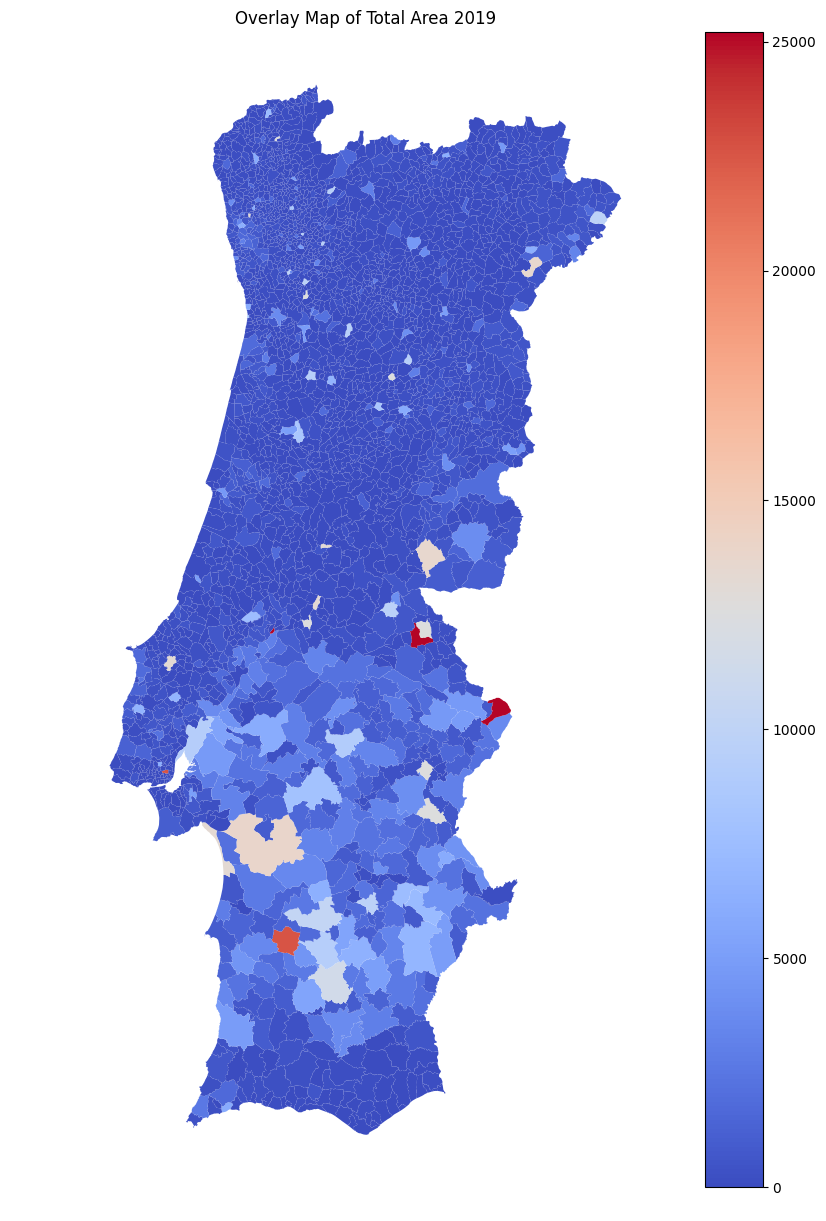

In [28]:
# Aggregate Area_2019 by Freguesia
grouped_data = merged_data.groupby('Freguesia')['Area_2019'].sum().reset_index()

# Merge grouped data with map_data to include Freguesias with no crop data
merged_map = map_data.merge(grouped_data, on='Freguesia', how='left')

# Set the areas with no crop data to 0
merged_map['Area_2019'].fillna(0, inplace=True)

# Plot the merged map without outlines
fig, ax = plt.subplots(figsize=(15, 15))
merged_map.plot(ax=ax, column='Area_2019', cmap='coolwarm', legend=True, edgecolor='none')

# Set the frame color and label color
ax.set_facecolor('white')
ax.tick_params(colors='white')
for spine in ax.spines.values():
    spine.set_edgecolor('white')

plt.title('Overlay Map of Total Area 2019')
plt.show()
